# Train sklearn models with simple pipeline

In this notebook we train Logistic regression and SVM classifier from sklearn and compare their perfomance.

In [1]:
import sys

import numpy as np
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

sys.path.append('../..')

from batchflow.models import SklearnModel
from batchflow.models.torch import VGG7
from batchflow.opensets import MNIST
from batchflow import B, V, D, Pipeline

Load MNIST dataset.

In [2]:
dataset = MNIST()

Pipeline preprocessing image actions include:
1. Transform images from PIL to np.array.   
2. Reshape them to 2 dimension arrays where the number of rows equal to the batch size.

You can train during single pipeline execution couple of models.   
Each model get the same batch of data.

In [3]:
BATCH_SIZE = 64
num_classes = dataset.num_classes
train_pipeline = (dataset.train.p
                    .to_array()
                    .add_namespace(np)
                    .reshape(B('images'), (B('size'), -1), save_to=B('images'))
                    .train_model('LogReg', B.images, B.labels, 
                                 classes=list(range(num_classes)))
                    .train_model('SVM', B.images, B.labels, 
                                 classes=list(range(num_classes)))
                    .run_later(BATCH_SIZE, n_iters=100, drop_last=True, shuffle=True, bar=True)
           )

Sklean models with partial_fit attribute support batch wise training and can be integrated into pipeline.

Initialize SVM and Logistic Regression models by specifying estimator in the config.

In [4]:
(train_pipeline.before
        .init_model('static', SklearnModel, 'SVM', 
                    config = dict(estimator = SGDClassifier(loss='hinge')))
        .init_model('static', SklearnModel, 'LogReg',
                    config = dict(estimator = SGDClassifier(loss='log')))
)

In [5]:
train_pipeline.run()

100%|██████████| 100/100 [00:00<00:00, 117.19it/s]


During test pipeline we execute the same steps and calculate metrics for each model.

In [6]:
test_pipeline = (dataset.test.p
                    .import_model('LogReg', train_pipeline)
                    .import_model('SVM', train_pipeline)
                    .to_array()
                    .add_namespace(np)
                    .reshape(B('images'), (B('size'), -1), save_to=B('images'))
                    .predict_model('LogReg', B('images'), save_to=(V('L_predictions')))
                    .predict_model('SVM', B('images'), save_to=(V('S_predictions')))
                    .gather_metrics('class', B.labels, V('L_predictions'), num_classes=num_classes,
                                    fmt='labels', save_to=V('L_metrics', mode='a'))
                    .gather_metrics('class', B.labels, V('S_predictions'), num_classes=num_classes,
                                    fmt='labels', save_to=V('S_metrics', mode='a'))
                    .run_later(BATCH_SIZE, n_epochs=1, drop_last=False, shuffle=True, bar=True)
            )

In [7]:
(test_pipeline.before
            .init_variable('S_metrics', default=None)
            .init_variable('L_metrics', default=None)
            .init_variable('S_predictions')
            .init_variable('L_predictions')
)

In [8]:
test_pipeline.run()

100%|██████████| 157/157 [00:01<00:00, 121.91it/s]


In [9]:
logreg_metrics = test_pipeline.v('L_metrics')
svm_metrics = test_pipeline.v('S_metrics')

In [10]:
logreg_metrics.evaluate('acc'), svm_metrics.evaluate('acc') 

(0.8460390127388535, 0.7829418789808917)

In [11]:
batch = test_pipeline.next_batch(5, shuffle=True)

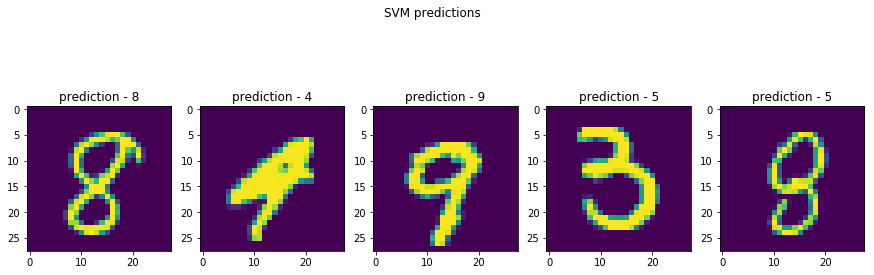

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('SVM predictions')
for i in range(len(ax)):
    ax[i].imshow((batch.images[i].reshape(28, 28)).astype(int))
    class_pred = batch.pipeline.v('S_predictions')[i]
    ax[i].title.set_text('prediction - {}'.format(class_pred))